In [46]:
# Source : https://www.datacamp.com/tutorial/lstm-python-stock-market

import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf

In [14]:
# Load CSV

filePath = f"Dataset/AAPL_2012-01-01-2023-01-01.csv"
df = pd.read_csv(filePath)

In [15]:
print(df.head())
print(df.columns)
df = df[['Date', 'Open', 'High', 'Low', 'Close']]
df.head()


         Date       Open       High        Low      Close  Adj Close  \
0  2012-01-03  14.621429  14.732143  14.607143  14.686786  12.449687   
1  2012-01-04  14.642857  14.810000  14.617143  14.765714  12.516597   
2  2012-01-05  14.819643  14.948214  14.738214  14.929643  12.655558   
3  2012-01-06  14.991786  15.098214  14.972143  15.085714  12.787854   
4  2012-01-09  15.196429  15.276786  15.048214  15.061786  12.767570   

      Volume  
0  302220800  
1  260022000  
2  271269600  
3  318292800  
4  394024400  
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


,Date,Open,High,Low,Close
0,2012-01-03,14.621429,14.732143,14.607143,14.686786
1,2012-01-04,14.642857,14.810000,14.617143,14.765714
2,2012-01-05,14.819643,14.948214,14.738214,14.929643
3,2012-01-06,14.991786,15.098214,14.972143,15.085714
4,2012-01-09,15.196429,15.276786,15.048214,15.061786


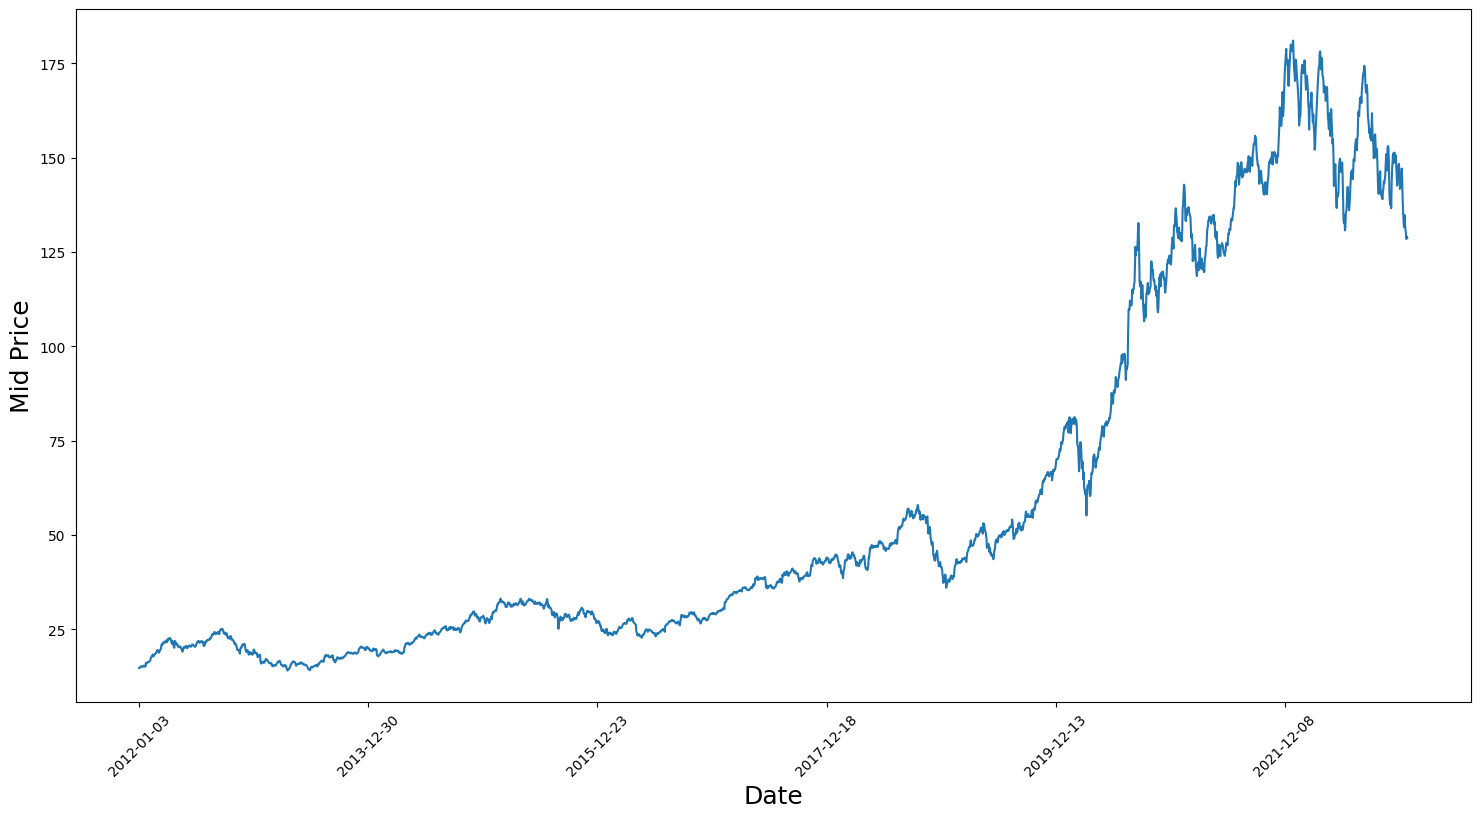

In [16]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()


In [18]:
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'High'].values
low_prices = df.loc[:,'Low'].values
mid_prices = (high_prices+low_prices)/2.0


In [19]:
df.shape

(2768, 5)

In [21]:
trainingSamples = 2000
train_data = mid_prices[:trainingSamples]
test_data = mid_prices[trainingSamples:]
print(train_data.shape)
print(test_data.shape)

(2000,)
(768,)


In [23]:
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)
print(train_data.shape)
print(test_data.shape)

(2000, 1)
(768, 1)


In [35]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 25
for di in range(0,len(train_data)-smoothing_window_size,smoothing_window_size):
    # print(train_data[di:di+smoothing_window_size,:])
    # print(di, di+smoothing_window_size)
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])


In [36]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)


In [40]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(1950):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)


In [42]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))


MSE error for standard averaging: 0.00355


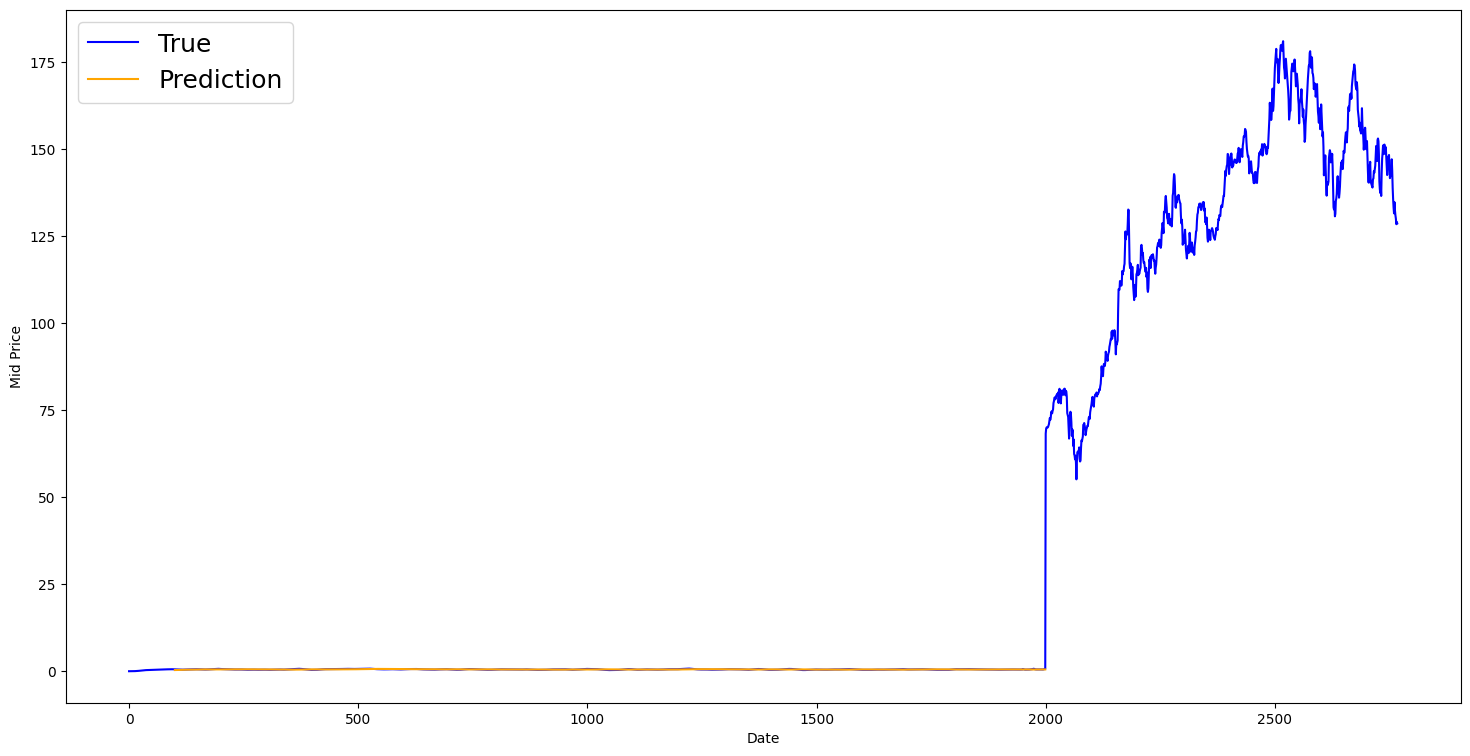

In [43]:

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()


In [44]:

class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)




Unrolled index 0
	Inputs:  [0.         0.38158113 0.48770937 0.58881336 0.4008039 ]

	Output: [2.1802505e-05 3.8673413e-01 5.1316226e-01 6.1211395e-01 3.9711696e-01]


Unrolled index 1
	Inputs:  [2.1802505e-05 3.8385454e-01 4.9725565e-01 5.9623772e-01 3.9711696e-01]

	Output: [0.00131207 0.39206213 0.51316226 0.61211395 0.39545956]


Unrolled index 2
	Inputs:  [1.4501344e-04 3.8673413e-01 5.0590867e-01 6.0404962e-01 3.9545956e-01]

	Output: [0.00131207 0.39426643 0.52277195 0.63811415 0.400492  ]


Unrolled index 3
	Inputs:  [5.1997940e-04 3.8958827e-01 5.1316226e-01 6.1211395e-01 3.9592308e-01]

	Output: [0.00131207 0.3993782  0.5188227  0.64731526 0.39592308]


Unrolled index 4
	Inputs:  [0.00131207 0.39206213 0.5188227  0.62048584 0.39788705]

	Output: [0.00443486 0.40279043 0.52547675 0.62048584 0.39788705]


In [49]:
D = 1 # Dimensionality of the data. Since your data is 1-D this would be 1
num_unrollings = 50 # Number of time steps you look into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

# tf.reset_default_graph() # This is important in case you run this multiple times


In [50]:
# Input data.
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))


AttributeError: module 'tensorflow' has no attribute 'placeholder'